# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

In [254]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#from pykliep import DensityRatioEstimator
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
#from sklearn.datasets import make_regression

Далее я скопировал DensityRatioEstimator https://github.com/srome/pykliep/blob/master/pykliep.py
    для устранения устранения проблы репрезентативности данных

In [126]:
class DensityRatioEstimator:
    """
    Class to accomplish direct density estimation implementing the original KLIEP 
    algorithm from Direct Importance Estimation with Model Selection
    and Its Application to Covariate Shift Adaptation by Sugiyama et al. 
    
    The training set is distributed via 
                                            train ~ p(x)
    and the test set is distributed via 
                                            test ~ q(x).
                                            
    The KLIEP algorithm and its variants approximate w(x) = q(x) / p(x) directly. The predict function returns the
    estimate of w(x). The function w(x) can serve as sample weights for the training set during
    training to modify the expectation function that the model's loss function is optimized via,
    i.e.
    
            E_{x ~ w(x)p(x)} loss(x) = E_{x ~ q(x)} loss(x).
    
    Usage : 
        The fit method is used to run the KLIEP algorithm using LCV and returns value of J 
        trained on the entire training/test set with the best sigma found. 
        Use the predict method on the training set to determine the sample weights from the KLIEP algorithm.
    """
    
    def __init__(self, max_iter=5000, num_params=[.1,.2], epsilon=1e-4, cv=3, sigmas=[.01,.1,.25,.5,.75,1], random_state=None, verbose=0):
        """ 
        Direct density estimation using an inner LCV loop to estimate the proper model. Can be used with sklearn
        cross validation methods with or without storing the inner CV. To use a standard grid search.
        
        
        max_iter : Number of iterations to perform
        num_params : List of number of test set vectors used to construct the approximation for inner LCV.
                     Must be a float. Original paper used 10%, i.e. =.1
        sigmas : List of sigmas to be used in inner LCV loop.
        epsilon : Additive factor in the iterative algorithm for numerical stability.
        """
        self.max_iter = max_iter
        self.num_params = num_params
        self.epsilon = epsilon
        self.verbose = verbose
        self.sigmas = sigmas
        self.cv = cv
        self.random_state = 0
        
    def fit(self, X_train, X_test, alpha_0=None):
        """ Uses cross validation to select sigma as in the original paper (LCV).
            In a break from sklearn convention, y=X_test.
            The parameter cv corresponds to R in the original paper.
            Once found, the best sigma is used to train on the full set."""
        
        # LCV loop, shuffle a copy in place for performance.
        cv = self.cv
        chunk = int(X_test.shape[0]/float(cv))
        if self.random_state is not None:
            np.random.seed(self.random_state)
        X_test_shuffled = X_test.copy()
        np.random.shuffle(X_test_shuffled)
        
        j_scores = {}
        
        if type(self.sigmas) != list:
            self.sigmas = [self.sigmas]
        
        if type(self.num_params) != list:
            self.num_params = [self.num_params]
        
        if len(self.sigmas) * len(self.num_params) > 1:
            # Inner LCV loop
            for num_param in self.num_params:
                for sigma in self.sigmas:
                    j_scores[(num_param,sigma)] = np.zeros(cv)
                    for k in range(1,cv+1):
                        if self.verbose > 0:
                            print('Training: sigma: %s    R: %s' % (sigma, k))
                        X_test_fold = X_test_shuffled[(k-1)*chunk:k*chunk,:] 
                        j_scores[(num_param,sigma)][k-1] = self._fit(X_train=X_train, 
                                                         X_test=X_test_fold,
                                                         num_parameters = num_param,
                                                         sigma=sigma)
                    j_scores[(num_param,sigma)] = np.mean(j_scores[(num_param,sigma)])

            sorted_scores = sorted([x for x in j_scores.iteritems() if np.isfinite(x[1])], key=lambda x :x[1], reverse=True)
            if len(sorted_scores) == 0:
                warnings.warn('LCV failed to converge for all values of sigma.')
                return self
            self._sigma = sorted_scores[0][0][1]
            self._num_parameters = sorted_scores[0][0][0]
            self._j_scores = sorted_scores
        else:
            self._sigma = self.sigmas[0]
            self._num_parameters = self.num_params[0]
            # best sigma
        self._j = self._fit(X_train=X_train, X_test=X_test_shuffled, num_parameters=self._num_parameters, sigma=self._sigma)

        return self # Compatibility with sklearn
        
    def _fit(self, X_train, X_test, num_parameters, sigma, alpha_0=None):
        """ Fits the estimator with the given parameters w-hat and returns J"""
        
        num_parameters = num_parameters
        
        if type(num_parameters) == float:
            num_parameters = int(X_test.shape[0] * num_parameters)

        self._select_param_vectors(X_test=X_test, 
                                   sigma=sigma,
                                   num_parameters=num_parameters)
        
        X_train = self._reshape_X(X_train)
        X_test = self._reshape_X(X_test)
        
        if alpha_0 is None:
            alpha_0 = np.ones(shape=(num_parameters,1))/float(num_parameters)
        
        self._find_alpha(X_train=X_train,
                         X_test=X_test,
                         num_parameters=num_parameters,
                         epsilon=self.epsilon,
                         alpha_0 = alpha_0,
                         sigma=sigma)
        
        return self._calculate_j(X_test,sigma=sigma)
    
    def _calculate_j(self, X_test, sigma):
        return np.log(self.predict(X_test,sigma=sigma)).sum()/X_test.shape[0]
    
    def score(self, X_test):
        """ Return the J score, similar to sklearn's API """
        return self._calculate_j(X_test=X_test, sigma=self._sigma)

    @staticmethod   
    def _reshape_X(X):
        """ Reshape input from mxn to mx1xn to take advantage of numpy broadcasting. """
        if len(X.shape) != 3:
            return X.reshape((X.shape[0],1,X.shape[1]))
        return X
    
    def _select_param_vectors(self, X_test, sigma, num_parameters):
        """ X_test is the test set. b is the number of parameters. """ 
        indices = np.random.choice(X_test.shape[0], size=num_parameters, replace=False)
        self._test_vectors = X_test[indices,:].copy()
        self._phi_fitted = True
        
    def _phi(self, X, sigma=None):
        
        if sigma is None:
            sigma = self._sigma
        
        if self._phi_fitted:
            return np.exp(-np.sum((X-self._test_vectors)**2, axis=-1)/(2*sigma**2))
        raise Exception('Phi not fitted.')

    def _find_alpha(self, alpha_0, X_train, X_test, num_parameters, sigma, epsilon):
        A = np.zeros(shape=(X_test.shape[0],num_parameters))
        b = np.zeros(shape=(num_parameters,1))

        A = self._phi(X_test, sigma)
        b = self._phi(X_train, sigma).sum(axis=0) / X_train.shape[0] 
        b = b.reshape((num_parameters, 1))
        
        out = alpha_0.copy()
        for k in range(self.max_iter):
            out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
            out += b*(((1-np.dot(np.transpose(b),out))/np.dot(np.transpose(b),b)))
            out = np.maximum(0,out)
            out /= (np.dot(np.transpose(b),out))
            
        self._alpha = out
        self._fitted = True
        
    def predict(self, X, sigma=None):
        """ Equivalent of w(X) from the original paper."""
        
        X = self._reshape_X(X)
        if not self._fitted:
            raise Exception('Not fitted!')
        return np.dot(self._phi(X, sigma=sigma), self._alpha).reshape((X.shape[0],))


# 1. Подготовка данных

gold_recovery_train.csv — обучающая выборка;   
gold_recovery_test.csv — тестовая выборка;     
gold_recovery_full.csv — исходные данные.       

In [127]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')

In [128]:
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

In [129]:
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [130]:
#df_train.to_csv('gold_recovery_train.csv')
#df_test.to_csv('gold_recovery_test.csv')
#df_full.to_csv('gold_recovery_full.csv')

### 1.1 Изучение данных 

In [131]:
def missing_data(data):  # функция для поиска пропусков
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent']).head(40)

In [132]:
def find_duplicates_by_columns(df):  # функция для поиска дубликатов по столбцам
    duplicates = []
    column = []
    for i in df.columns:
        duplicates.append(df[i].duplicated().sum())
        column.append(i)
    duplicates = pd.Series(duplicates) 
    column = pd.Series(column) 
    return pd.concat([column, duplicates], axis = 1,
                     keys = ['column', 'duplicates']).sort_values(by = 'duplicates',ascending = False).head(40)

##### df_train

In [133]:
df_train.head(40)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [134]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [135]:
missing_data(df_train)

,Total,Percent
rougher.output.recovery,2573,15.260973
rougher.output.tail_ag,2250,13.345196
rougher.output.tail_sol,2249,13.339265
rougher.output.tail_au,2249,13.339265
secondary_cleaner.output.tail_sol,1986,11.779359
rougher.input.floatbank11_xanthate,1904,11.293001
final.output.recovery,1521,9.021352
primary_cleaner.input.sulfate,1307,7.752076
primary_cleaner.input.depressant,1262,7.485172
rougher.calculation.au_pb_ratio,1242,7.366548


In [136]:
find_duplicates_by_columns(df_train)

,column,duplicates
12,primary_cleaner.input.feed_size,12924
67,secondary_cleaner.output.tail_sol,4300
48,rougher.output.recovery,2914
66,secondary_cleaner.output.tail_pb,2413
16,primary_cleaner.output.concentrate_sol,2402
65,secondary_cleaner.output.tail_ag,2399
68,secondary_cleaner.output.tail_au,2397
51,rougher.output.tail_sol,2393
46,rougher.output.concentrate_sol,2323
49,rougher.output.tail_ag,2284


В обучающем датафреме в целом пропусков немного. Больше всех их среди признаков, отражающих параметоры продукта на этапе флотации. Процент пропусков для этих этих признаков в интервале 11-15%

В каждом столбце в среднем по две тысяче дубликатов. Как правило столбцы с дубликатами описывают концентрацию веществ, которая хоть и указана до 6 знаков после запятой, но на мой взгляд может повторяться, поэтому удалять стороки с повторяющимися значенимями не буду. 12000 дубликатов для размеров гранул сырья выглядят логично и согласно бизнес-процессу.   

##### df_test

In [137]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [138]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

В тестовом датасете нет финальных параметров продукта, которые есть в обучающем наборе. 

In [139]:
missing_data(df_test)

,Total,Percent
rougher.input.floatbank11_xanthate,353,6.028005
primary_cleaner.input.sulfate,302,5.157104
primary_cleaner.input.depressant,284,4.849727
rougher.input.floatbank10_sulfate,257,4.388661
primary_cleaner.input.xanthate,166,2.834699
rougher.input.floatbank10_xanthate,123,2.100410
rougher.input.feed_sol,67,1.144126
rougher.input.floatbank11_sulfate,55,0.939208
rougher.input.feed_rate,40,0.683060
secondary_cleaner.state.floatbank3_a_air,34,0.580601


In [140]:
find_duplicates_by_columns(df_test)

,column,duplicates
3,primary_cleaner.input.feed_size,4291
17,rougher.input.feed_sol,443
14,rougher.input.feed_pb,391
18,rougher.input.feed_au,390
13,rougher.input.feed_ag,390
22,rougher.input.floatbank11_xanthate,352
41,secondary_cleaner.state.floatbank3_b_air,331
1,primary_cleaner.input.sulfate,301
39,secondary_cleaner.state.floatbank3_a_air,286
2,primary_cleaner.input.depressant,283


Количество пропусков в имеющихся в  df_test столбцах незначительно. Максимум - 5%

Считаю, что дубликаты по столцам допустимы.

In [141]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [142]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [143]:
missing_data(df_full)

,Total,Percent
rougher.output.recovery,3119,13.730410
rougher.output.tail_ag,2737,12.048776
rougher.output.tail_sol,2736,12.044374
rougher.output.tail_au,2736,12.044374
rougher.input.floatbank11_xanthate,2257,9.935728
secondary_cleaner.output.tail_sol,2215,9.750836
final.output.recovery,1963,8.641486
rougher.calculation.au_pb_ratio,1627,7.162353
primary_cleaner.input.sulfate,1609,7.083113
primary_cleaner.input.depressant,1546,6.805776


В общем датафреме в целом пропусков немного. Больше всех их среди признаков, показателя восстановления золота после флотации (14%). Процент пропусков для отвальных хвостов после флорации тоже заметен и составил ~ 12 % для каждого из трех элементов (ag, sol, au)

<font color='green'>Очень подробный отчет, прекрасная работа. </font>


### 1.2 Проверка правильности расчетов эффективности обогащения

 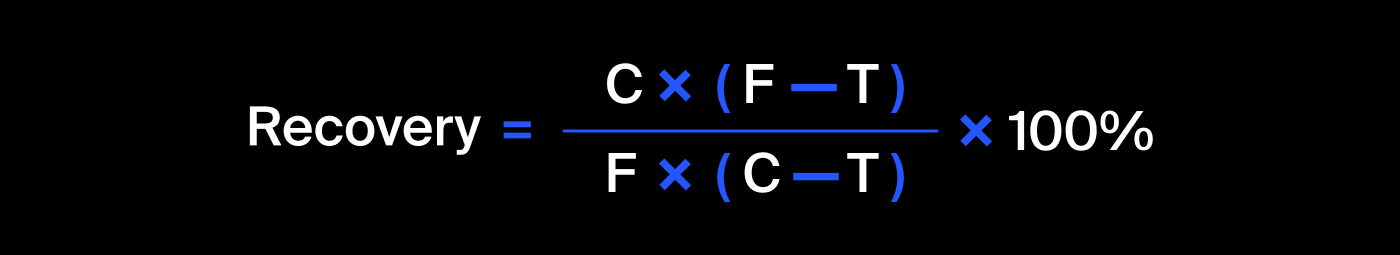

где:   
C — доля золота в концентрате после флотации/очистки (rougher.output.concentrate_au);  
F — доля золота в сырье/концентрате до флотации/очистки (rougher.input.feed_au);  
T — доля золота в отвальных хвостах после флотации/очистки (rougher.output.tail_au).  

In [144]:
#rougher.output.recovery 
recovery_check = ( (df_train['rougher.output.concentrate_au'] *
( df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'] )) /
(df_train['rougher.input.feed_au'] * ( df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au'] ) ) ) * 100 

In [145]:
recovery_check

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64

In [146]:
df_train['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 16860, dtype: float64

##### Расчет MAE

Заполню нулями пропуски в 'rougher.output.recovery', чтобы не возникло проблем с подсчетом MAE. 
Пропуски rougher.output.recovery скорее всего являются результатом отсутствия значений, по которым счиаталось recovery

In [147]:
df_train['rougher.output.recovery'].isna().sum()

2573

In [148]:
df_train['rougher.output.recovery'] = df_train['rougher.output.recovery'].fillna(0)

In [149]:
flag = 0
for i in df_train['rougher.output.recovery']:
    if i > 100:
        flag +=1
print(flag)
        
    

0


In [150]:
recovery_basic = df_train['rougher.output.recovery']

In [151]:
recovery_basic.isna().sum()

0

In [152]:
recovery_check.isna().sum()

2283

Заполню нулями пропуски в recovery_check, чтобы не возникло проблем с подсчетом MAE:

In [153]:
recovery_check = recovery_check.fillna(0)

In [154]:
recovery_check.isna().sum()

0

In [155]:
#посмотрим сколько значений >100
recovery_check[recovery_check > 100].count()

125

In [156]:
#посмотрим сколько значений < 0
recovery_check[recovery_check < 0].count()

165

In [157]:
#посмотрим на них
recovery_check[recovery_check < 0].sort_values()

3084         -inf
3086         -inf
3087         -inf
3088         -inf
3089         -inf
           ...   
15681   -0.243304
16286   -0.235187
15680   -0.231296
14000   -0.209102
14845   -0.061871
Length: 165, dtype: float64

Все значения recovery_check, которые меньше 0 или больше 100 я заменю на нули, потому что recovery расчитано в процентах и любые значения recovery больше 100 или меньше 1 говорят о каких то аномалиях, поэтому, исходя из логики людей, заменивших отрицательные значения recovery на 0, я поступлю так же

In [158]:
#recovery_check = recovery_check.replace(recovery_check[recovery_check > 100], np.nan)

In [159]:
recovery_check[recovery_check > 100] = 0
recovery_check[recovery_check < 0] = 0

In [160]:
#заменю бесконечности пропусками
recovery_check = recovery_check.replace([np.inf, -np.inf], np.nan)

In [161]:
recovery_check = recovery_check.dropna()

In [162]:
recovery_check[recovery_check > 0].sort_values()

13890      1.075750
8099       1.412748
1200       2.520854
4615       4.323054
1262       4.323914
            ...    
13035    100.000000
13036    100.000000
13037    100.000000
13038    100.000000
13039    100.000000
Length: 13967, dtype: float64

In [163]:
mean_absolute_error(list(recovery_check), list(recovery_basic))

8.00350954615662e-15

#### Вывод

MAE между recovery, расчитанным мной и recovery, посчитанным в таблице довольно маленькая. Другими словами,  средняя ошибка составила 0.8 %, что незначительно. Следовательно, изначальный расчет recovery - верный

### 1.3 Анализ недоступных df_test признаков

In [164]:
# чтобы понять, какие признаки отсутствуют в df_test, сравню датафреймы по колоннам 
columns_full = df_full.columns
columns_test = df_test.columns

for i in columns_full:
    flag = 0
    for j in columns_test:
        if i == j:
            flag = 1
    if flag != 1:
        print(i)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

In [165]:
df_full.columns.difference(df_test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

#### Вывод

В тестовой выборке не хватает параметров продукта на всех этапах технологического процесса. Другими словами, тип  отсутствующих признаков - параметры продукта 

Также в тестовой выборке не хватает расчетных характеристик

### 1.4 Предобработка данных 

#### Преобразование типов данных

Преобразуем  столбец с датами в формат даты и время

In [166]:
df_full['date'] = pd.to_datetime(df_full['date'])

In [167]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [168]:
df_test['date'] = pd.to_datetime(df_test['date'])

#### Преобразование индексов

In [169]:
#преобразую индексы для удобной работы с датасетами

#df_train.index = pd.Index(df_train['date'])
#df_train = df_train.drop(['date'], axis=1)

In [170]:
#df_full.index = pd.Index(df_full['date'])
#df_full = df_full.drop(['date'], axis=1)

In [171]:
#df_test.index = pd.Index(df_test['date'])
#df_test = df_test.drop(['date'], axis = 1)

#### Заполнение пропусков

Cначала заполню пропуски в df_full, затем всем данные из full скопирую в df_train и test по датам. 

Пропущенные значения в  rougher.output.recovery я мог бы не трогать, чтобы потом заполнить их предсказаниями модели 1 для того , чтобы занова обучить модель на уже всех значниях с учетом прдесказаний ранее отсутвующих. Однако делать этого всего ради 13% пропусков я не буду (Поправьте меня, если я не прав). Удалять строки с пропусками rougher.output.recovery тоже не буду, т.к. не хочу терять данные признаков для обучения. Как вариант заменю пропуски rougher.output.recovery
на соседние значения. Я считаю этот подход логичным, т.к. отсутствующие значения параметров, по которым  считатается rougher.output.recovery тоже будут заменены мною на соседние значения ( это основано на предположении, что пропуски в rougher.output.recovery - результат пропусков значений параметров, по которым он считался) . В итоге абсолютно все пропуски всех признаков заменю на соседние во всех трех датасетах

Проверю предположение, что пропуски в rougher.output.recovery - результат пропусков значений параметров, по которым он считался:

In [172]:
df_nan = df_full.loc[df_full['rougher.output.recovery'].isna(), ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']]

In [173]:
df_nan 

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
53,3.507147,7.548341,2.187465
99,0.000000,0.000000,NaN
100,0.000000,0.000000,NaN
101,0.000000,0.000000,NaN
102,0.000000,0.000000,NaN
...,...,...,...
22553,6.038533,11.035269,1.343570
22554,10.712677,10.943209,1.858404
22555,0.010000,10.149224,1.729189
22556,0.010000,10.591710,1.481931


In [174]:
df_nan.dropna().count()

rougher.output.concentrate_au    382
rougher.input.feed_au            382
rougher.output.tail_au           382
dtype: int64

Как  видно, только ~10% процентов строк с пропущенными значениями rougher.output.recovery  имеют все необходимые для расчета параметры, в остальнх параметры пропущены => предположение можно принять

##### df_full

In [175]:
df_full = df_full.fillna(method='ffill') #замена всех пропусков

##### df_train

In [176]:
df_train = df_train['date'].to_frame() 

In [177]:
df_train = df_train.merge(df_full, on = 'date', how = 'left')

In [178]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16860 non-null float64
final.output.concentrate_pb                           16860 non-null float64
final.output.concentrate_sol                          16860 non-null float64
final.output.concentrate_au                           16860 non-null float64
final.output.recovery                                 16860 non-null float64
final.output.tail_ag                                  16860 non-null float64
final.output.tail_pb                                  16860 non-null float64
final.output.tail_sol                                 16860 non-null float64
final.output.tail_au                                  16860 non-null float64
primary_cleaner.input.sulfate                         16860 non-null float64
primary_cleaner.input.depressant     

In [179]:
#df_train = df_train.drop(['Unnamed: 0'], axis = 1)

##### df_test

In [180]:
#выделю только те признаки, которые необходимы для test

In [181]:
df_full_for_test = df_full[df_test.columns] #сначала беру кусок полного датафрейма, содержащий информацию без пропусков для test

In [182]:
df_test = df_test['date'].to_frame() # избавляюсь от лишней информации в таблице, оставляя только дату необходимых строк

In [183]:
df_test = df_test.merge(df_full_for_test, on = 'date', how = 'left') # добавляю в тест уже исправленные значения

In [184]:
#df_test =df_test.drop(['Unnamed: 0'], axis = 1)

In [185]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null float64
ro

## Вывод

#### 1.1 Изучение данных

1.  В обучающем датафреме в целом пропусков немного. Больше всех их среди признаков, отражающих параметоры продукта на этапе флотации. Процент пропусков для этих этих признаков в интервале 11-15%     
В каждом столбце в среднем по две тысяче дубликатов. Как правило столбцы с дубликатами описывают концентрацию веществ, которая хоть и указана до 6 знаков после запятой, но на мой взгляд может повторяться, поэтому удалять стороки с повторяющимися значенимями не буду. 12000 дубликатов для размеров гранул сырья выглядят логично и согласно бизнес-процессу.        
2. Количество пропусков в имеющихся в df_test столбцах незначительно. Максимум - 5%. Считаю, что дубликаты по столцам допустимы.
В тестовом датасете нет финальных параметров продукта, которые есть в обучающем наборе.      
3. В общем датафреме в целом пропусков немного. Больше всех их среди признаков, показателя восстановления золота после флотации (14%). Процент пропусков для отвальных хвостов после флорации тоже заметен и составил ~ 12 % для каждого из трех элементов (ag, sol, au)      

#### 1.2 Проверка правильности расчетов эффективности обогащения

MAE между recovery, расчитанным мной и recovery, посчитанным в таблице довольно маленькая. Другими словами,  средняя ошибка составила 0.8 %, что незначительно. Следовательно, изначальный расчет recovery - верный 

#### 1.3 Анализ недоступных df_test признаков

В тестовой выборке не хватает параметров продукта на всех этапах технологического процесса. Другими словами, тип отсутствующих признаков - параметры продукта.

#### 1.4 Предобработка данных

1. Тип данных в столбцe date заменил на c object на DateTime
2. Cначала заполнил пропуски в df_full c gjvjom. ffill, затем все данные из df_full скопирую в df_train и df_test по датам. 

# 2. Анализ данных

### 2.1 Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

 до очистки (после флотаци):   
rougher.output.concentrate_au       
rougher.output.concentrate_ag                               
rougher.output.concentrate_pb         

 после первого этапа очистки:   
primary_cleaner.output.concentrate_ag                      
primary_cleaner.output.concentrate_pb                       
primary_cleaner.output.concentrate_au         

после второго этапа очистки:    
final.output.concentrate_ag                              
final.output.concentrate_pb                               
final.output.concentrate_au                                      

In [186]:
#подготовим данный для трех гистограмм:

In [187]:
#df_full.pivot_table(index = 'date', columns = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb'])

concentration_input = df_full[['rougher.input.feed_au','rougher.input.feed_ag', 
                               'rougher.input.feed_pb', 'rougher.input.feed_sol'
                               ]]

concentration_before_cleaner = df_full[['rougher.output.concentrate_au',
                                        'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']] 
concentration_after_first_cleaner = df_full[['primary_cleaner.output.concentrate_au',
                                            'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol']]
concentratiom_after_second_cleaner = df_full[['final.output.concentrate_au',
                                              'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']]

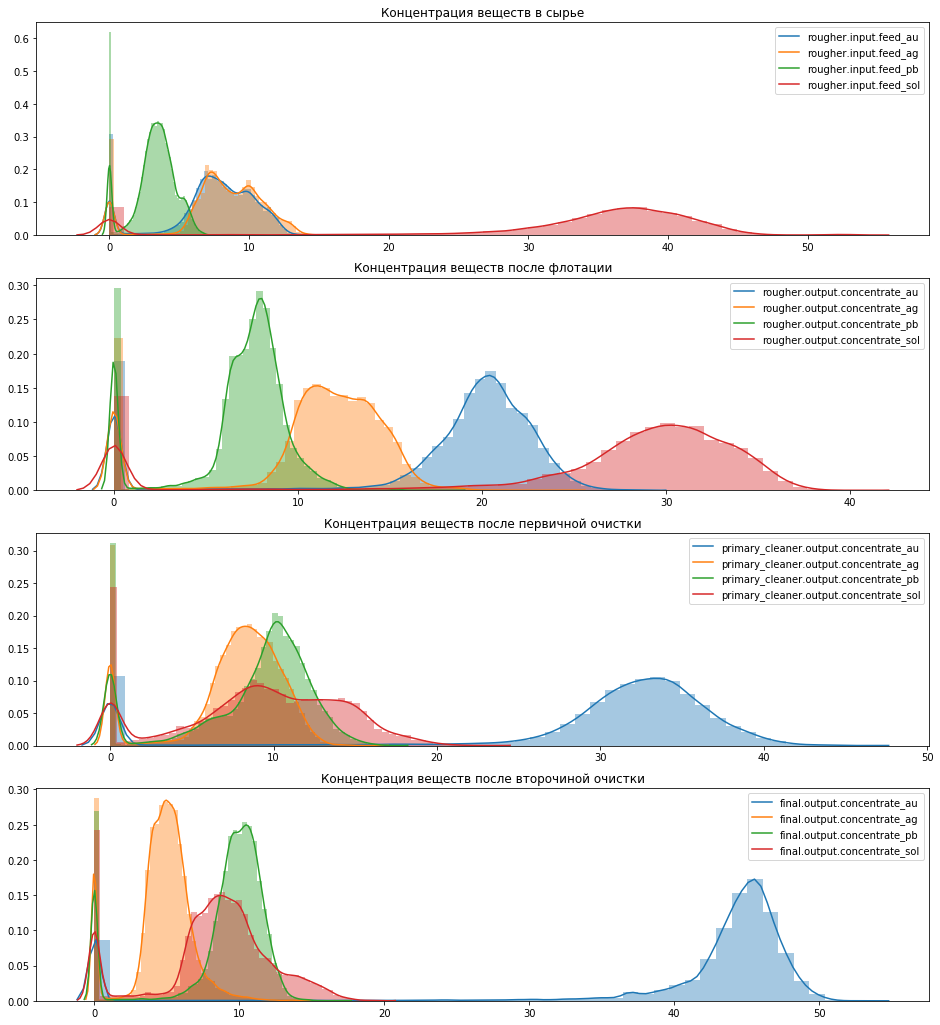

In [188]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (16,18))

#concentration_before_cleaner.plot(kind = 'hist', ax = ax1, figsize = (10,20), )

ax1.set_title('Концентрация веществ в сырье')
for col in concentration_input.columns:
    sns.distplot(df_full[col], ax = ax1, kde_kws = {'label': col}, axlabel = False)
ax2.set_title('Концентрация веществ после флотации')
for col in concentration_before_cleaner.columns:
    sns.distplot(df_full[col], ax = ax2, kde_kws = {'label': col}, axlabel = False)
ax3.set_title('Концентрация веществ после первичной очистки')
for col in concentration_after_first_cleaner.columns:
    sns.distplot(df_full[col], ax = ax3, kde_kws = {'label': col}, axlabel = False)
ax4.set_title('Концентрация веществ после второчиной очистки')
for col in concentratiom_after_second_cleaner.columns:
    sns.distplot(df_full[col], ax = ax4, kde_kws = {'label': col}, axlabel = False)



### Вывод

1. Перед первой стадией очистки доля золота среди сырья, подаваемого на первый этап очистки составляет в среднем 21%, серебра ~10-15%, свинца ~ 7%
2. После первой стадии очистки доля золота составляет в среднем 34%, серебра ~9% и свинца ~10%
3. После второй стадии очистки доля золота составляет в средеем 45%, серебра ~5% и свинца ~10%

Общий тренд: на каждом последующем этапе доля золота значительно увеличевается, доля свинца увеличвается незначительно, а доля серебра снижается. 

### 2.2. Сравние распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

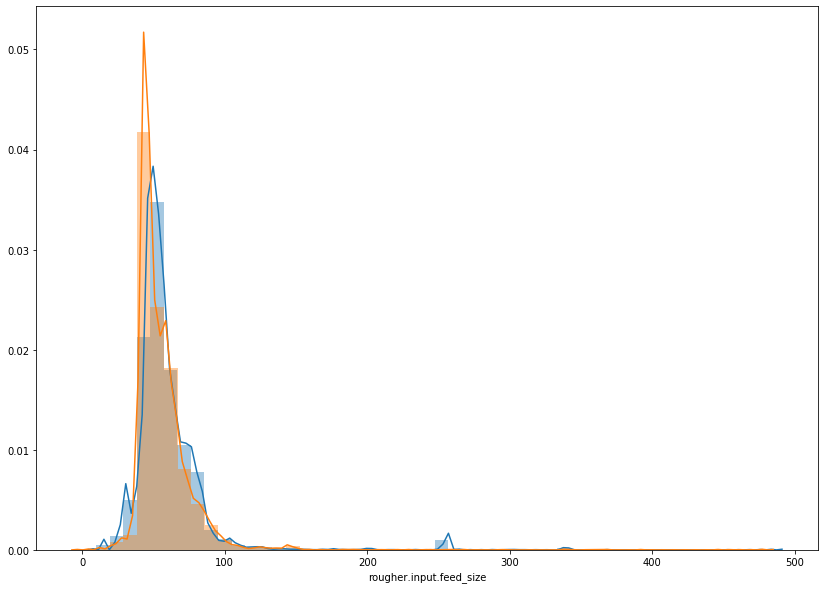

In [189]:
fig, ax = plt.subplots(figsize = (14,10))
sns.distplot(df_train['rougher.input.feed_size'], ax = ax)
sns.distplot(df_test['rougher.input.feed_size'], ax = ax)


In [190]:
fig, ax = plt.subplots(figsize = (14,10))
sns.distplot(df_train['primary_cleaner.input.feed_size'], ax = ax)
sns.distplot(df_test['primary_cleaner.input.feed_size'], ax = ax)

Error in callback <function flush_figures at 0x7fd336fcee60> (for post_execute):


KeyboardInterrupt: 

### Вывод

Распределения размера гранул на обучающей и тестовой выборке особо не отличаются друг от друга, поэтому оценка модели будет адекватной

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

Добавлю в каждый датафрейм столбецы с суммарной конценетрацией вещетсв


In [191]:
#сумма веществ в сырье
df_full['rougher_input_sum_concentrate'] = (df_full['rougher.input.feed_ag'] 
                                            + df_full['rougher.input.feed_pb'] + df_full['rougher.input.feed_sol'] 
                                            + df_full['rougher.input.feed_au'])

df_train['rougher_input_sum_concentrate'] = (df_train['rougher.input.feed_ag'] 
                                            + df_train['rougher.input.feed_pb'] 
                                             + df_train['rougher.input.feed_sol'] + df_train['rougher.input.feed_au'])

df_test['rougher_input_sum_concentrate'] = (df_test['rougher.input.feed_ag'] 
                                            + df_test['rougher.input.feed_pb'] 
                                             + df_test['rougher.input.feed_sol'] + df_test['rougher.input.feed_au'])

In [192]:
# cумма веществ в черновом концентрате
df_full['rougher_output_sum_concentrate'] = (df_full['rougher.output.concentrate_ag'] 
                                            + df_full['rougher.output.concentrate_pb'] + df_full['rougher.output.concentrate_sol'] 
                                            + df_full['rougher.output.concentrate_au'])

df_train['rougher_output_sum_concentrate'] = (df_train['rougher.output.concentrate_ag'] 
                                            + df_train['rougher.output.concentrate_pb'] + df_train['rougher.output.concentrate_sol'] 
                                            + df_train['rougher.output.concentrate_au'])

In [193]:
# сумма веществ в финальном концентрате
df_full['final_output_sum_concentrate'] = (df_full['final.output.concentrate_ag'] 
                                            + df_full['final.output.concentrate_pb'] + df_full['final.output.concentrate_sol'] 
                                            + df_full['final.output.concentrate_au'])

df_train['final_output_sum_concentrate'] = (df_train['final.output.concentrate_ag'] 
                                            + df_train['final.output.concentrate_pb'] + df_train['final.output.concentrate_sol'] 
                                            + df_train['final.output.concentrate_au'])

In [194]:
df_full_stat = df_full[['rougher_input_sum_concentrate','rougher_output_sum_concentrate','final_output_sum_concentrate']]
df_train_stat = df_train[['rougher_input_sum_concentrate','rougher_output_sum_concentrate','final_output_sum_concentrate']]
df_test_stat = df_test['rougher_input_sum_concentrate']

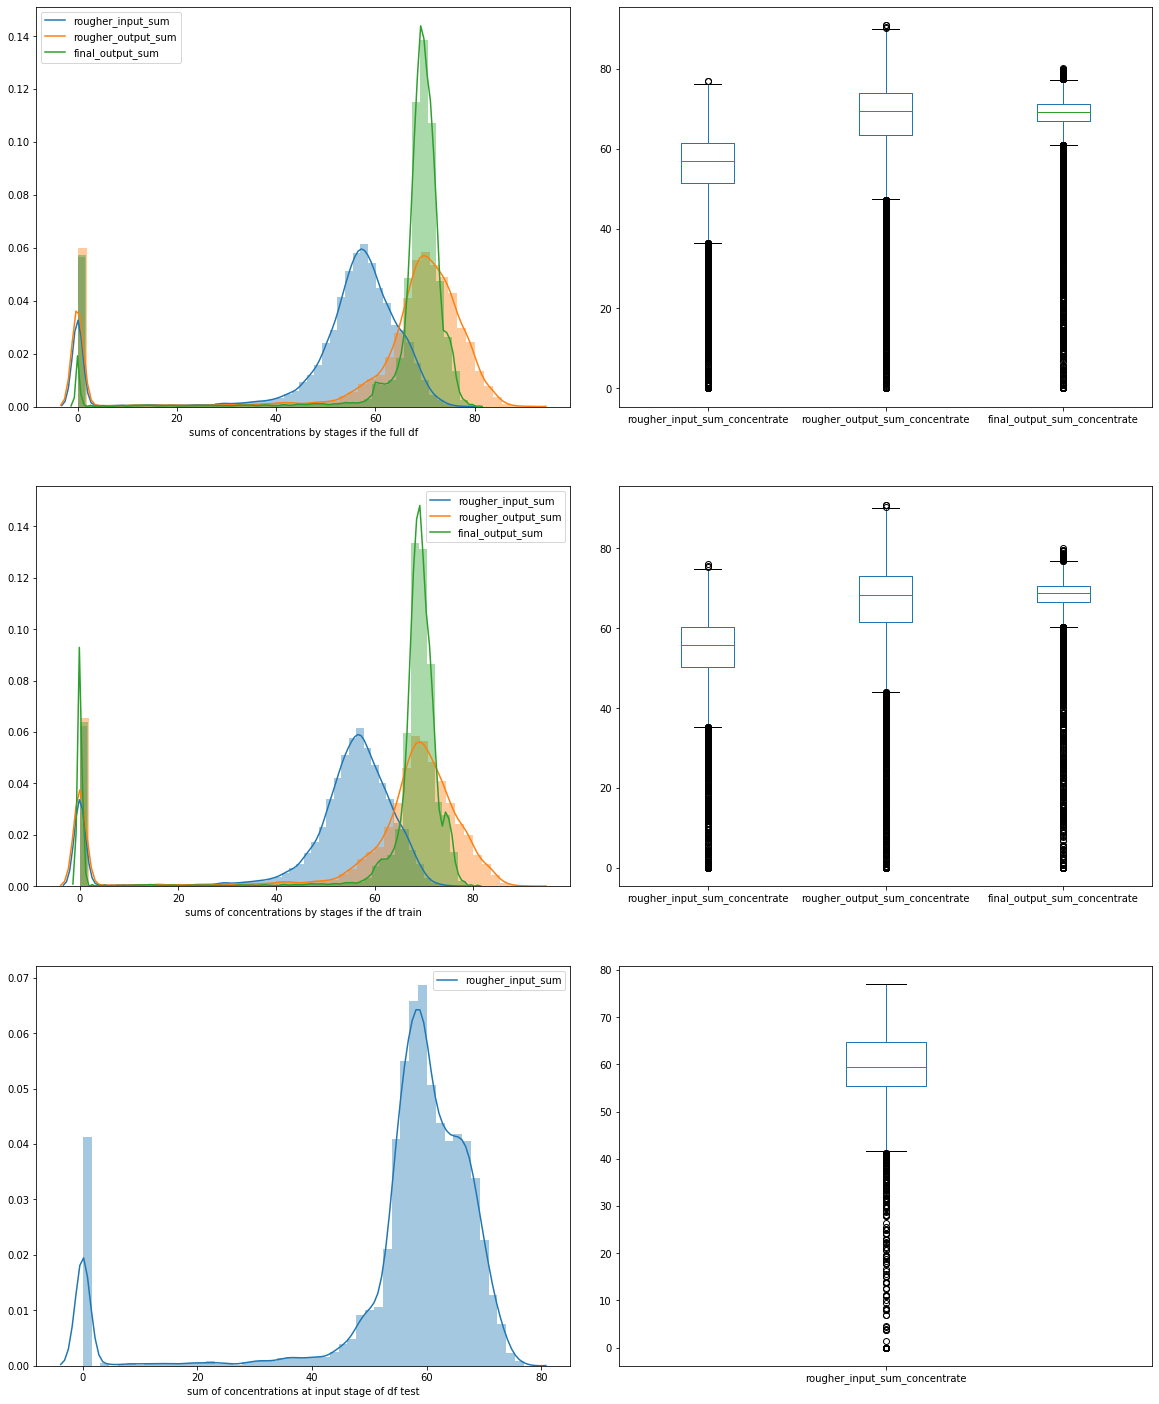

In [195]:
#axs = [ax1, ax2, ax3, ax4, ax5, ax6]
#fig, axs = plt.subplots(3,2, figsize = (15,18))
#sns.distplot(df_full['rougher_input_sum_concentrate'], ax = ax1, kde_kws = {'label': 'rougher_input_sum'})
#sns.distplot(df_full['rougher_output_sum_concentrate'], ax = ax1, kde_kws = {'label': 'rougher_output_sum'})
#sns.distplot(df_full['final_output_sum_concentrate'], ax = ax1, kde_kws = {'label': 'final_output_sum'})



fig = plt.figure(figsize = (20,25))
ax1 = fig.add_subplot(3,4,(1,2))
ax2 = fig.add_subplot(3,4, (3,4))
sns.distplot(df_full['rougher_input_sum_concentrate'], ax = ax1, kde_kws = {'label': 'rougher_input_sum'})
sns.distplot(df_full['rougher_output_sum_concentrate'], ax = ax1, kde_kws = {'label': 'rougher_output_sum'})
sns.distplot(df_full['final_output_sum_concentrate'], ax = ax1, kde_kws = {'label': 'final_output_sum'})
ax1.set_xlabel('sums of concentrations by stages if the full df')
df_full_stat.plot(kind = 'box', ax = ax2)

ax3 = fig.add_subplot(3,4, (5,6))
ax4 = fig.add_subplot(3,4, (7,8))

sns.distplot(df_train['rougher_input_sum_concentrate'], ax = ax3, kde_kws = {'label': 'rougher_input_sum'})
sns.distplot(df_train['rougher_output_sum_concentrate'], ax = ax3, kde_kws = {'label': 'rougher_output_sum'})
sns.distplot(df_train['final_output_sum_concentrate'], ax = ax3, kde_kws = {'label': 'final_output_sum'})
ax3.set_xlabel('sums of concentrations by stages if the df train')
df_train_stat.plot(kind = 'box', ax = ax4)



ax5 = fig.add_subplot(3,4, (9,10))
ax6 = fig.add_subplot(3,4, (11,12))

sns.distplot(df_test['rougher_input_sum_concentrate'], ax = ax5, kde_kws = {'label': 'rougher_input_sum'})
ax5.set_xlabel('sum of concentrations at input stage of df test')
df_test_stat.plot(kind = 'box', ax = ax6)

### Вывод 

1. Из распределения сумм концентраций веществ на разных этапах, можно сделать вывод, что указанные Ag, Pb, Au и Sol - не единственные вещества в технологическом процессе, так как их суммарная концентрация не составляет 100%. 
2. Также, исходя из гистограмм суммарная концентрация увеличивается после флотации, и ёё разброс резко скоращается после финальной очистки. 
3. Тренировочная выборка по суммам концентраций идентична полной
4. Суммарная концентрация веществ в сырье в тестовой выборке в среднем на 2-5% больше, чем в полной выборке 
5. Во всех выборках существет достаточно выбросов с значениеми близкими к нулю. От них я избавился. Также, иpбавлюсь от выбросов, которые отражены на диаграме размаха для df_full 

#### Удаление выбросов

В функции буду сравнивать суммы долей веществ на разных этапах технологического процесса между full выборкой и тестовой с тренировочной. Если в тестовой или в тренировочной выборке будут найдены в столбцах 'rougher_input_sum_concentrate', 'rougher_output_sum_concentrate' и 'final_output_sum_concentrate' выбросы, выходящие за границы для выбросов для df_full  (объекты, суммарная концентрация веществ на одном их этпапов которых  которых больше Q3 + 1.5*IQR и меньше Q1 - 1.5*IQR  для df_full ), то они будут удалены вместе со строками, содержащими аномальные значения

In [196]:
#суммы величин, доступные в выборках train и full
sums = ['rougher_input_sum_concentrate', 'rougher_output_sum_concentrate', 'final_output_sum_concentrate']

In [197]:
# суммы величин, дотсупные в выборке test
sums_test = ['rougher_input_sum_concentrate']

In [198]:

#basic_data_frame - датафрейм, на который нужно опираться для расчета границ, отделяющих допустимые значения от выбростов
#basic_column - cтолбцы , по выбросы в которых будут анализироваться

def graph_creator(data_frame, basic_data_frame, basic_columns): 
    for column in basic_columns:
        print('Диаграмма размаха для столбца из full_df')
        info = basic_data_frame[column].describe()# получаем информацию о первом (Q1) и третьем квартилях (Q3)  
        q1 = info[4]
        q3 = info[6]
        iqr = q3 - q1   # считаем межквартильный размах
        border = iqr*1.5   # cчитаем расстояние от Q1 и Q3 до границы, за которой расположены выбросы
        plt.ylim(-0.8*border, q3 + border + 0.8*border) 
        basic_data_frame.boxplot(column = column)  # строим диаграмму размаха
        plt.show()
        print('')
        print('Избавляемся от строк, где есть выбросы в столбце  {} , значения \n которых больше Q3 + 1.5*IQR ({:.3f}) и меньше Q1 - 1.5*IQR ({:.3f}).'.format(column, q3 + border,q1 - border))
        
       
        data_frame[column] = data_frame.loc[ (data_frame[column] >= (q1 - border))
                                           & (data_frame[column] <= (q3 + border)), column]
       
        print('')
    print('теперь в датафреме стоолько пропусков: ')
    print( data_frame.isna().sum())
    improved_data_frame = data_frame.dropna(axis = 0)   # удалим все строки, где функция удалила выбросные суммы
    improved_data_frame.reset_index(drop=True, inplace = True)
    print('')
    print('пропуски удалены')
    print('теперь пропусков: ')
    print( improved_data_frame.isna().sum())
    
    print('Диаграммы размаха для сумм исправленного датасета')
    #for i in basic_columns:
        #improved_data_frame[i].plot(kind = 'box', ylim = (0,100), figsize = (10,10))
    return improved_data_frame

Диаграмма размаха для столбца из full_df


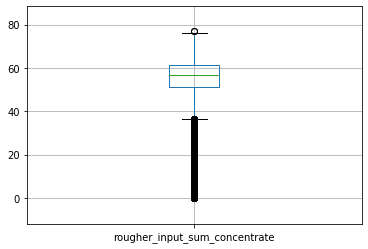


Избавляемся от строк, где есть выбросы в столбце  rougher_input_sum_concentrate , значения 
 которых больше Q3 + 1.5*IQR (76.414) и меньше Q1 - 1.5*IQR (36.392).

теперь в датафреме стоолько пропусков: 
date                                            0
primary_cleaner.input.sulfate                   0
primary_cleaner.input.depressant                0
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                  0
primary_cleaner.state.floatbank8_a_air          0
primary_cleaner.state.floatbank8_a_level        0
primary_cleaner.state.floatbank8_b_air          0
primary_cleaner.state.floatbank8_b_level        0
primary_cleaner.state.floatbank8_c_air          0
primary_cleaner.state.floatbank8_c_level        0
primary_cleaner.state.floatbank8_d_air          0
primary_cleaner.state.floatbank8_d_level        0
rougher.input.feed_ag                           0
rougher.input.feed_pb                           0
rougher.input.feed_rate                       

In [199]:
# избавлюсь от выбросов в тест
df_test = graph_creator(df_test, df_full, sums_test)

In [200]:
#избавлюсь от выбросов в трейн

Диаграмма размаха для столбца из full_df


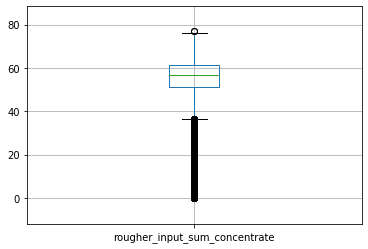


Избавляемся от строк, где есть выбросы в столбце  rougher_input_sum_concentrate , значения 
 которых больше Q3 + 1.5*IQR (76.414) и меньше Q1 - 1.5*IQR (36.392).

Диаграмма размаха для столбца из full_df


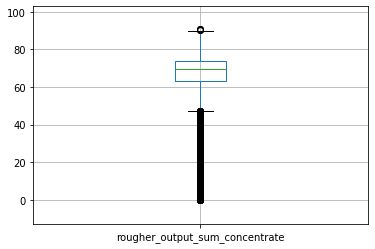


Избавляемся от строк, где есть выбросы в столбце  rougher_output_sum_concentrate , значения 
 которых больше Q3 + 1.5*IQR (90.076) и меньше Q1 - 1.5*IQR (47.275).

Диаграмма размаха для столбца из full_df


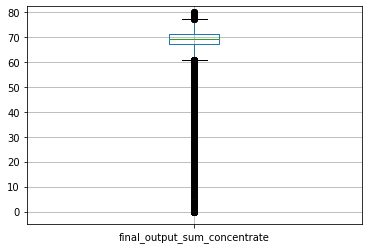


Избавляемся от строк, где есть выбросы в столбце  final_output_sum_concentrate , значения 
 которых больше Q3 + 1.5*IQR (77.304) и меньше Q1 - 1.5*IQR (60.855).

теперь в датафреме стоолько пропусков: 
date                                             0
final.output.concentrate_ag                      0
final.output.concentrate_pb                      0
final.output.concentrate_sol                     0
final.output.concentrate_au                      0
                                              ... 
secondary_cleaner.state.floatbank6_a_air         0
secondary_cleaner.state.floatbank6_a_level       0
rougher_input_sum_concentrate                 2027
rougher_output_sum_concentrate                2568
final_output_sum_concentrate                  2520
Length: 90, dtype: int64

пропуски удалены
теперь пропусков: 
date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol  

In [201]:
df_train = graph_creator(df_train, df_full, sums)

In [202]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13409 entries, 0 to 13408
Data columns (total 90 columns):
date                                                  13409 non-null datetime64[ns]
final.output.concentrate_ag                           13409 non-null float64
final.output.concentrate_pb                           13409 non-null float64
final.output.concentrate_sol                          13409 non-null float64
final.output.concentrate_au                           13409 non-null float64
final.output.recovery                                 13409 non-null float64
final.output.tail_ag                                  13409 non-null float64
final.output.tail_pb                                  13409 non-null float64
final.output.tail_sol                                 13409 non-null float64
final.output.tail_au                                  13409 non-null float64
primary_cleaner.input.sulfate                         13409 non-null float64
primary_cleaner.input.depressant     

In [203]:
df_train.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher_input_sum_concentrate,rougher_output_sum_concentrate,final_output_sum_concentrate
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,51.680034,66.424950,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,50.659114,67.012710,63.957723
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,50.609929,66.103793,64.311180
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,51.061546,65.752751,63.573449
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,47.859163,65.908382,64.004667
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915,48.838521,64.955919,63.646320
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470,49.120760,65.372419,63.156407
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070,50.790724,65.180132,62.908843
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188,50.550288,65.625127,64.185763
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855,51.941235,65.408849,64.185200


Проверим результаты работы функции

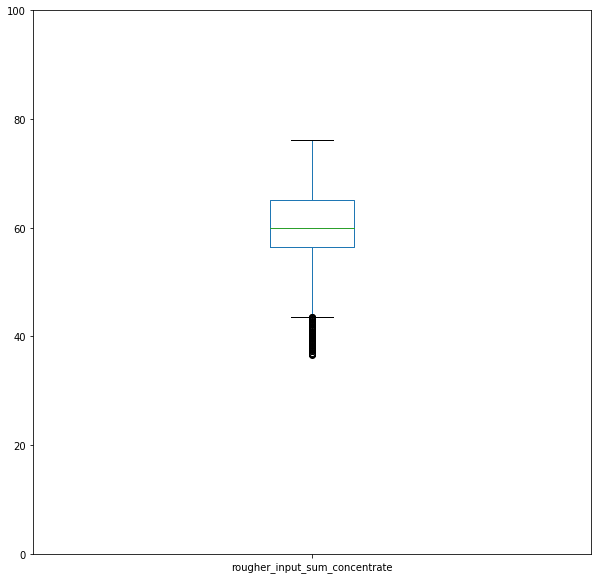

In [204]:
df_test['rougher_input_sum_concentrate'].plot(kind = 'box', ylim = (0,100), figsize = (10,10))

Как видно из диаграммы размаха, все значения, являющимися выбросами для df_full удалены

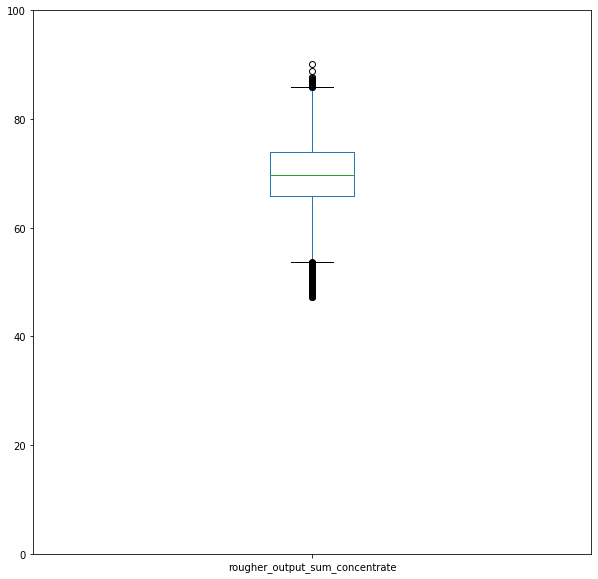

In [205]:
df_train['rougher_output_sum_concentrate'].plot(kind = 'box', ylim = (0,100), figsize = (10,10))

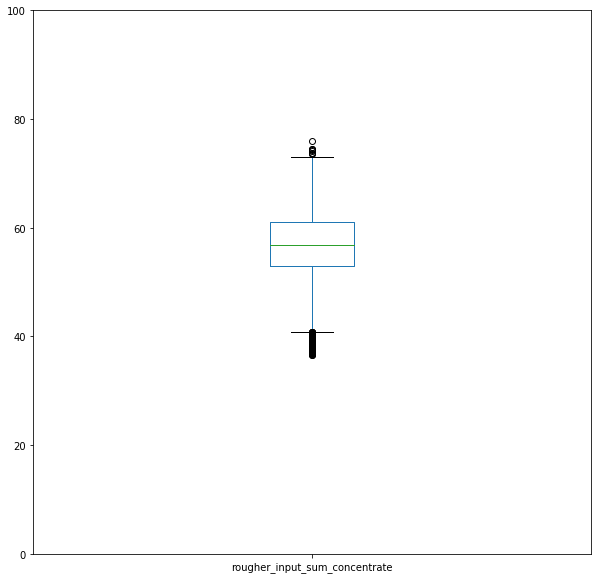

In [206]:
df_train['rougher_input_sum_concentrate'].plot(kind = 'box', ylim = (0,100), figsize = (10,10))

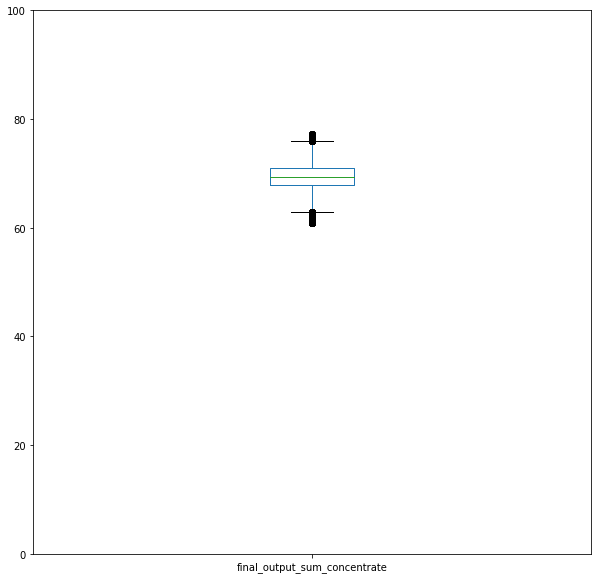

In [207]:
df_train['final_output_sum_concentrate'].plot(kind = 'box', ylim = (0,100), figsize = (10,10))

### Вывод

#### 2.1 Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.
1. Перед первой стадией очистки доля золота среди сырья, подаваемого на первый этап очистки составляет в среднем 21%, серебра ~10-15%, свинца ~ 7%
2. После первой стадии очистки доля золота составляет в среднем 34%, серебра ~9% и свинца ~10%
3. После второй стадии очистки доля золота составляет в средеем 45%, серебра ~5% и свинца ~10%
Общий тренд: на каждом последующем этапе доля золота значительно увеличевается, доля свинца увеличвается незначительно, а доля серебра снижается. 

#### 2.2. Сравние распределения размеров гранул сырья на обучающей и тестовой выборках
Распределения размера гранул на обучающей и тестовой выборке особо не отличаются друг от друга, поэтому оценка модели будет адекватной

#### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

1. Из распределения сумм концентраций веществ на разных этапах, можно сделать вывод, что указанные Ag, Pb, Au и Sol - не единственные вещества в технологическом процессе, так как их суммарная концентрация не составляет 100%. 
2. Также, исходя из гистограмм суммарная концентрация увеличивается после флотации, и ёё разброс резко скоращается после финальной очистки. 
3. Тренировочная выборка по суммам концентраций идентична полной
4. Суммарная концентрация веществ в сырье в тестовой выборке в среднем на 2-5% больше, чем в полной выборке 
5. Во всех выборках существет достаточно выбросов с значениеми близкими к нулю. 
6. Избавился от всех выбросов в тестовой и обучающей выборках опираясь на выбросы для df_full.Я посчитал это корректным т.к. скорее всего выбросы - результаты неудачных замеров либо ошибки в подаче концентраций сырья.  В df_full выбросы не удалял., т.к. не вижу в этом смысла.


# 3. Модель

### 3.1. Функция  для вычисления итоговой sMAPE.

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

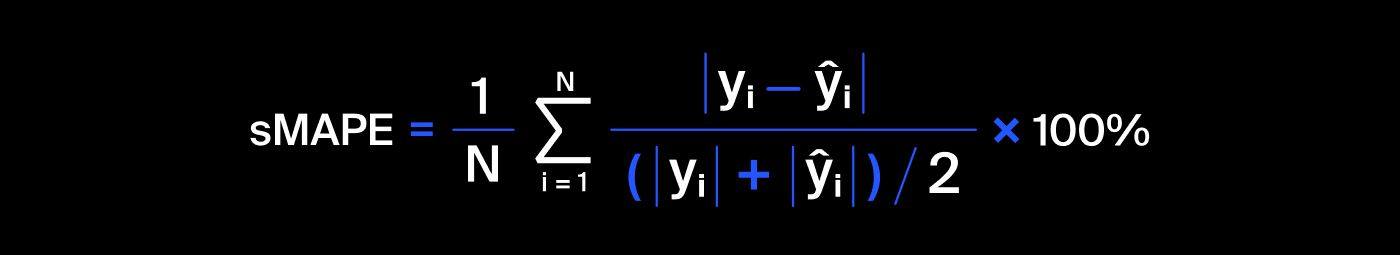

In [208]:
def SMAPE(y_true, y_pred):
    return ((abs(y_true - y_pred) / ((abs(y_true)+ abs(y_pred)) / 2)).mean())*100


    #sum = 0
    #for i in range(len(y_true)):
        #element = abs(y_true[i] - y_pred[i]) / ((abs(y_true[i]) + abs(y_pred[i]))/2) * 100
        #sum += element
    #smape = float(sum/len(y_true))
    #return smape    



### Функция для вычисления взвешеннной SMAPE

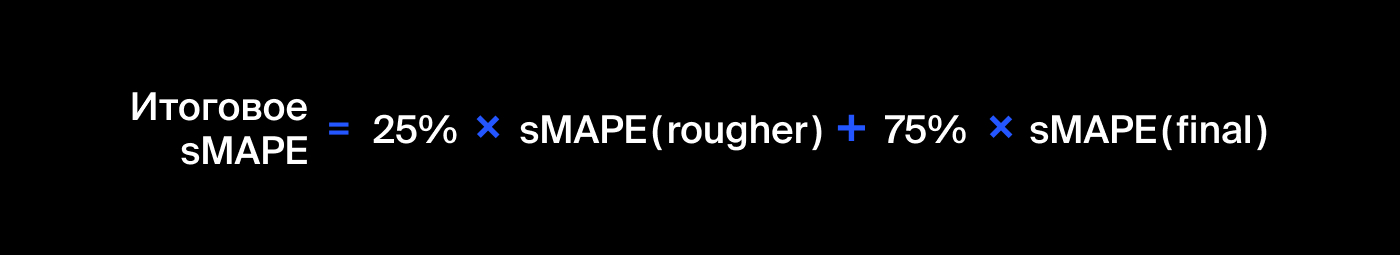

In [209]:
def SMAPE_weighted(y_true, y_pred):
     return 0.25*SMAPE(y_true.T[0], y_pred.T[0]) + 0.75*SMAPE(y_true.T[1], y_pred.T[1])


### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

#### 3.2.1 Преобразование test и train

In [210]:
# удалю лишнее из train (те, которых нет в test)
# добавлю в тест целевые признаки по датам из full

Предполагаю, что значение state (Возможные значения для блока [тип_параметра]), которые описывают состояние этапа является изветным на всех стадиях технологического процесса. Поэтому все такие признаки будут включины мною как для обучения модели предсказания rougher.output.recovery, так и для final.output.recovery

In [211]:
train = df_train[df_test.columns.values]

In [212]:
train['final.output.recovery'] = df_train['final.output.recovery']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [213]:
train['rougher.output.recovery'] = df_train['rougher.output.recovery']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [214]:
# создадам датафрем с колонками data, rougher_output_recovery и final_output_recovery
df_full_for_merge= df_full[['date', 'rougher.output.recovery', 'final.output.recovery']]

In [215]:
#Замержим по датам df_test и df_full_for_merge
test = df_test.merge(df_full_for_merge, on = 'date', how = 'left')

#### 3.2.2 Деление train и test на фичи и таргеты 

In [216]:
#Фичи - все значения, которые есть в тест.

In [217]:
 # от признака с датой я избавлюсь т.к. вместе с ним я не смогу далее скалировать величины 
    
train_features = train.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)
train_target = train[['rougher.output.recovery', 'final.output.recovery']].values

test_features = test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)
test_target = test[['rougher.output.recovery', 'final.output.recovery']].values


In [218]:
train_target

array([[87.10776293, 70.54121591],
       [86.84326051, 69.26619763],
       [86.84230826, 68.11644507],
       ...,
       [88.89057853, 67.00218885],
       [89.858126  , 65.52324622],
       [89.51495973, 70.28145415]])

#### 3.2.3 Масштабтрование признаков 

In [219]:
#делаю это для модели регресии 

In [220]:
scaler = StandardScaler()  
scaler.fit(train_features)

train_features_scaled = pd.DataFrame(scaler.transform(train_features), columns = train_features.columns, index = train_features.index)



In [221]:

test_features_scaled = pd.DataFrame(scaler.transform(test_features), columns = test_features.columns, index = test_features.index)


In [222]:
# переведу фичи из datafrabe в array, чтобы не возникало ошибок в fit()
train_features = train_features.values
test_features = test_features.values

train_features_scaled = train_features_scaled.values
test_features_scaled = test_features_scaled.values

### Обучение моделей

#### 3.2.4 Обучение модели для предсказания rougher.output.recovery и final.output.recovery

##### Устранение нерепрезентативности  (Covariate Shift)

In [193]:

kliep = DensityRatioEstimator()
kliep.fit(train_features, test_features) # keyword arguments are X_train and X_test
weights = kliep.predict(train_features)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: overflow encountered in true_divide


AttributeError: 'dict' object has no attribute 'iteritems'

##### Модель регрессии 

In [223]:
reg = LinearRegression() 

# гиперпараметры, которые можно попробовать, используя GridSearchCV

parameters_reg = {'normalize': [True, False], 
              'fit_intercept': [True, False], 
             }
scorer_reg = make_scorer(SMAPE_weighted, greater_is_better=False)
grid_obj_reg = GridSearchCV(reg, parameters_reg, scoring = scorer_reg) 


In [224]:
grid_obj_reg = grid_obj_reg.fit(train_features_scaled, train_target)

# определить для reg_one лучшие гиперпараметры
reg = grid_obj_reg.best_estimator_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [228]:
# обучим лучший алгоритм
reg.fit(train_features_scaled, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [229]:
# создам необученную модель (пустую) с лучшими параметрами для кросс-валидации
reg_empty = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [237]:
#используем Кросс-валидацию для оценки модели
reg_score = cross_val_score(reg_empty, train_features_scaled, train_target, cv=6,  scoring=make_scorer(SMAPE_weighted, greater_is_better=False)).mean()

In [238]:
reg_score

-9.732235034106347

##### Модель RandomForest

In [239]:
#range(старт, стоп, шаг)
estimators_number = []
for i in range(1, 20, 5):
    estimators_number.append(i)

In [240]:
forest = RandomForestRegressor()

parametrs_forest = {'n_estimators': estimators_number}

scorer_forest = make_scorer(SMAPE_weighted, greater_is_better=False)
grid_obj_forest = GridSearchCV(forest, parametrs_forest, scoring = scorer_forest)


In [241]:
grid_obj_forest = grid_obj_forest.fit(train_features, train_target)

# определить для reg_one лучшие гиперпараметры
forest = grid_obj_forest.best_estimator_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [243]:
#обучим лучший алгоритм
forest.fit(train_features, train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=16,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [244]:
# создам необученную модель (пустую) с лучшими параметрами для кросс-валидации
forest_empty = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=16,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [245]:
#используем Кросс-валидацию для оценки модели
forest_score = cross_val_score(forest_empty, train_features, train_target, cv=6, scoring=make_scorer(SMAPE_weighted, greater_is_better=False))

In [247]:
forest_score.mean()

-9.319579953895486

##### Константная модель

In [262]:
dummy = DummyRegressor()

In [263]:
dummy.fit(train_features, train_target)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [264]:
dummy_score = cross_val_score(dummy, train_features, train_target, cv=6, scoring=make_scorer(SMAPE_weighted, greater_is_better=False))

In [265]:
dummy_score.mean()

-9.480938451740236

In [ ]:
На тренировочной выборке предсказания константной модели оказались даже лучше, чем модели регрессии

### Тестирование моделей 

In [269]:
prediction_reg = reg.predict(test_features_scaled)
smape_reg = SMAPE_weighted(test_target, prediction_reg)

In [270]:
smape_reg

9.473789514014223

In [271]:
prediction_forest = forest.predict(test_features)

In [272]:
smape_forest = SMAPE_weighted(test_target, prediction_forest)

In [273]:
smape_forest

10.171434013920152

In [274]:
prediction_dummy = dummy.predict(test_features)

In [275]:
smape_dummy = SMAPE_weighted(test_target, prediction_dummy)

In [276]:
smape_dummy

9.986235006752484

### Вывод

Метрика SMAPE достигла 9,3 % на моделе линейной регрессии. Константная модель обошла случайный лес (9,9% против 10,1%)

Лучшая модель - модель регресии


Предварительно были удалены объкты-выбросы как из тренировочной, так и из тестовой выборок, у которых суммы концентраций веществ на разных этапах были аномальными (выходили за усы boxplotА). Выбросы  были удалены как из тренировочной, так и из тестовой выборок. До этого все пропуски были заполнены c помощью ffill